# Identifying phishing mails by using URL and mail features and ML based classification tools

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Constructing-Dataset" data-toc-modified-id="Constructing-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Constructing Dataset</a></span><ul class="toc-item"><li><span><a href="#Importing-libraries-and-defining-constants" data-toc-modified-id="Importing-libraries-and-defining-constants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importing libraries and defining constants</a></span></li><li><span><a href="#Downloading-and-extracting-mails-(phishing-and-ham-mails)" data-toc-modified-id="Downloading-and-extracting-mails-(phishing-and-ham-mails)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Downloading and extracting mails (phishing and ham mails)</a></span></li><li><span><a href="#Loading-mails" data-toc-modified-id="Loading-mails-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading mails</a></span></li><li><span><a href="#Mail-Features-extraction-functions" data-toc-modified-id="Mail-Features-extraction-functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Mail Features extraction functions</a></span><ul class="toc-item"><li><span><a href="#Mail-body-features" data-toc-modified-id="Mail-body-features-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Mail body features</a></span></li><li><span><a href="#URL-features" data-toc-modified-id="URL-features-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>URL features</a></span></li></ul></li><li><span><a href="#Constructing-dataset-by-extracting-various-features" data-toc-modified-id="Constructing-dataset-by-extracting-various-features-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Constructing dataset by extracting various features</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Visualization:-Matplotlib" data-toc-modified-id="Visualization:-Matplotlib-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualization: Matplotlib</a></span></li><li><span><a href="#Histogram,-PDF-and-CDF" data-toc-modified-id="Histogram,-PDF-and-CDF-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Histogram, PDF and CDF</a></span></li><li><span><a href="#Violin-plots" data-toc-modified-id="Violin-plots-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Violin plots</a></span></li><li><span><a href="#Principal-Component-Analysis" data-toc-modified-id="Principal-Component-Analysis-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Principal Component Analysis</a></span><ul class="toc-item"><li><span><a href="#PCA-for-visualization" data-toc-modified-id="PCA-for-visualization-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>PCA for visualization</a></span></li><li><span><a href="#PCA-for-dimentionality-reduction" data-toc-modified-id="PCA-for-dimentionality-reduction-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>PCA for dimentionality reduction</a></span></li></ul></li><li><span><a href="#t-SNE-using-Scikit-Learn" data-toc-modified-id="t-SNE-using-Scikit-Learn-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>t-SNE using Scikit-Learn</a></span></li></ul></li></ul></div>

## Constructing Dataset

### Importing libraries and defining constants

In [1]:
import os
from bs4 import BeautifulSoup
import mailparser
from collections import OrderedDict
import email
from urllib.request import urlretrieve
import tarfile
import shutil
import numpy as np
import glob
import mailparser
import re
import tldextract
import urllib.request
import warnings
import logging
import csv
import sys
import logging
import logging.config
import yaml
from logging import Formatter
from logging.handlers import RotatingFileHandler
URLREGEX = r"^(https?|ftp)://[^\s/$.?#].[^\s]*$"
URLREGEX_NOT_ALONE = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
FLASH_LINKED_CONTENT = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])+).*\.swf"
HREFREGEX = '<a\s*href=[\'|"](.*?)[\'"].*?\s*>'
IPREGEX = r"\b((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?))\b"
MALICIOUS_IP_URL = r"\b((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\/(www|http|https|ftp))\b"
EMAILREGEX = r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)"
GENERAL_SALUTATION = r'\b(dear|hello|Good|Greetings)(?:\W+\w+){0,6}?\W+(user|customer|seller|buyer|account holder)\b'
MAILS_DIR = 'mails'

TAR_DIR = os.path.join(MAILS_DIR, 'tar')


PHISHING_URL = '../mails/tar/phishing_mails.tar.xz'
HAM_URL = '../mails/tar/20030228_easy_ham_2.tar.bz2'
HARD_HAM_URL = '../mails/tar/20021010_hard_ham.tar.bz2'


with open('./logs/config/logging_config.yaml', 'r') as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)

logging.config.dictConfig(config)
logger = logging.getLogger('PhishingMailClassifier')
logger.debug('often makes a very good meal of %s', 'visiting tourists')
logger.info("Project Started\nConstants defined and libraries imported")


### Downloading and extracting mails (phishing and ham mails)

In [2]:
def download_dataset(url):
    """download and unzip data from a url into the specified path"""
    logger.info("Downloading dataset from '%s'",url)
    # create directory if it doesn't exist
    if not os.path.isdir(TAR_DIR):
        os.makedirs(TAR_DIR)

    filename = url.rsplit('/', 1)[-1]
    tarpath = os.path.join(TAR_DIR, filename)
    print(filename)
    # download the tar file if it doesn't exist
    try:
        tarfile.open(tarpath)
        logger.info("Opened tar '%s'",tarpath)
    except:
        urlretrieve(url, tarpath)
        logger.info("Retrieving from URL '%s'",url)

    with tarfile.open(tarpath) as tar:
        dirname = os.path.join(MAILS_DIR, tar.getnames()[0])
        logger.info("Directory Name '%s'",dirname)
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        tar.extractall(path=MAILS_DIR)

        cmds_path = os.path.join(dirname, 'cmds')
        if os.path.isfile(cmds_path):
            os.remove(cmds_path)

    return dirname

In [3]:
ham_dir = download_dataset(HAM_URL)
logger.info("Downloaded Easy Ham Mails")
hard_ham_dir = download_dataset(HARD_HAM_URL)
logger.info("Downloaded Hard Ham Mails")
phishing_dir = download_dataset(PHISHING_URL)
logger.info("Downloaded Easy Phishing Mails")

20030228_easy_ham_2.tar.bz2
20021010_hard_ham.tar.bz2
phishing_mails.tar.xz


### Loading mails

In [4]:

def load_mails(dirpath):
    """load emails from the specified directory"""

    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    logger.info("Loaded mails from '%s'",dirpath)
    return files

In [5]:
# load the datasets
phishing = load_mails(phishing_dir)
print("Number of phishing mails: ",len(phishing))
logger.debug("Number of phishing mails: %d",len(phishing))
ham = load_mails(ham_dir)
ham = ham + load_mails(hard_ham_dir)
print("Number of ham mails: ",len(ham))
logger.debug("Number of ham mails: %d",len(ham))

Number of phishing mails:  2239
Number of ham mails:  1650


#### OverSampling 

In [6]:
import random
import copy
sample = copy.deepcopy(ham)
random.shuffle(sample)
ham = ham + sample[:589]
print("Number of ham mails: ",len(ham))
logger.debug("After OverSampling\nNumber of ham mails: %d",len(ham))


Number of ham mails:  2239


### Mail Features extraction functions

#### Mail body features

In [7]:

def getMailBody(mail):
    try:
        mail_body = mailparser.parse_from_string(mail).body.lower()
    except UnicodeDecodeError as Argument:
        parsed_mail = email.message_from_string(mail)
        body = ""
        if parsed_mail.is_multipart():
            for part in parsed_mail.walk():
                # returns a bytes object
                payload = part.get_payload(decode=True)
                strtext = payload.decode()
                body += strtext
        else:
            payload = parsed_mail.get_payload(decode=True)
            strtext = payload.decode()
            body += strtext
        mail_body = body.lower()
    return mail_body



def presenceHTML(mail):
    msg = email.message_from_string(mail)
    return int((msg.get_content_type() == 'text/html') == True)


def presenceHTMLFORM(message):
    return int((re.compile(r'<\s?\/?\s?form\s?>', re.IGNORECASE).search(message)
             != None) == True)


def presenceHTMLIFRAME(message):
    return int(re.compile(r'<\s?\/?\s?iframe\s?>',
                      re.IGNORECASE).search(message) != None) == True


def presenceJavaScript(message):
    return int(re.compile(r'<\s?\/?\s?script\s?>',
                      re.IGNORECASE).search(message) != None) == True


def presenceFlashContent(message):
    swflinks = re.compile(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])+).*\.swf",
        re.IGNORECASE).findall(message)
    flashObject = re.compile(r'embed\s*src\s*=\s*\".*\.swf\"',
                             re.IGNORECASE).search(message)
    return int((swflinks != None and len(swflinks) > 0) or (flashObject != None)) == True


def presenceGeneralSalutation(message):
    return int(re.compile(GENERAL_SALUTATION,re.IGNORECASE).search(message) != None) == True


def numberOfAttachments(raw_mail):
    try:
        mail = mailparser.parse_from_string(raw_mail)
        count = len(mail.attachments)
        return count
    except:
        return 0
    

#### URL features

In [8]:
    
alexa_rank_cache = {}


def isURL(link):
    return re.compile(URLREGEX, re.IGNORECASE).search(link) is not None


def getURLs(mail_body):
    result = []
    cleanPayload = re.sub(r'\s+', ' ', mail_body)
    soup = BeautifulSoup(cleanPayload, 'html.parser')
    links = soup.find_all('a')
    i = 0
    for link in links:
        links[i] = link.get('href')
        i += 1

    for link in links:
        if isinstance(link, str) or isinstance(link, bytes):
            if isURL(link):
                result.append(link)
        else:
            continue

    urlregex = re.compile(URLREGEX_NOT_ALONE, re.IGNORECASE)
    links = urlregex.findall(cleanPayload)

    for link in links:
        if link not in result:
            result.append(link)

    res = list(OrderedDict.fromkeys(result))
    result = list(set(result))
    return result


def IPasURL(urls):
    result = []
    for url in urls:
        if re.compile(IPREGEX, re.IGNORECASE).search(url) and re.compile(IPREGEX, re.IGNORECASE).search(url).group(1) is not None:
            result.append(re.compile(IPREGEX, re.IGNORECASE).search(url).group(1))
    return int(len(result) > 0) == True


def textLinkDisparity(mail_body):
    soup = BeautifulSoup(mail_body, 'html.parser')
    lists = soup.find_all('a')
    for item in lists:
        link = item.get('href')
        for string in item.stripped_strings:
            text = str(string)
            text = text.strip().replace('\n', '')
            text = text.strip().replace('\t', ' ')
            if isURL(text) and text != link:
                return 1
    return 0


def maliciousURL(urls):
    for url in urls:
        if ((re.compile(IPREGEX, re.IGNORECASE).search(url)
             is not None) == True or (len(re.compile(r'(https?://)',re.IGNORECASE).findall(url)) > 1)
                or (len(re.compile(r'(www.)',re.IGNORECASE).findall(url)) > 1)
                or (len(re.compile(r'(\.com|\.org|\.co)',re.IGNORECASE).findall(url)) > 1))== True:
            return 1
        else:
            continue
    return 0


def hexadecimalURL(urls):
    for url in urls:
        if ((re.compile(r'%[0-9a-fA-F]+', re.IGNORECASE).search(url)
             is not None) == True):
            return 1
    return 0


def getAlexaRank(domain):
    if domain in alexa_rank_cache:
        return int(alexa_rank_cache[domain])
    try:
        xml = urllib.request.urlopen(
            'http://data.alexa.com/data?cli=10&dat=s&url=%s' %
            domain).read().decode('utf-8')
    except:
        alexa_rank_cache[domain] = 0
        return 0
    try:
        rank = (re.compile(r'RANK="(\d+)"',re.IGNORECASE).findall(xml))[1]
    except:
        rank = -1
    alexa_rank_cache[domain] = rank
    return int(rank)


def extractDomains(urls):
    domain_set = set()
    for url in urls:
        domain = tldextract.extract(url).registered_domain
        if domain not in domain_set:
            domain_set.add(domain)
        else:
            continue

    return list(domain_set)


def domainCounts(url):
    domains = tldextract.extract(url)
    count = (len(re.compile(r'\.',re.IGNORECASE).findall( domains.subdomain))) + \
        ((len(re.compile(r'\.',re.IGNORECASE).findall( domains.domain)))+1)
    if re.compile(IPREGEX,re.IGNORECASE).search(domains.domain) is not None:
        count -= 3
    return (count)


def presenceBadRankedURL(urls):
    domains = extractDomains(urls)
    max_rank = 0
    for domain in domains:
        rank = getAlexaRank(domain)
        max_rank = max(rank, max_rank)
        if rank == -1:
            return 0
    if max_rank > 70000:
        return 1
    return 0


def maxDomainsCounts(urls):
    count = 1
    for url in urls:
        count = max(domainCounts(url), count)
    return count


import json
import ast
def writeCache():
    with open('./cache/alexa_rank_cache.txt', 'w') as cache_file:
        cache_file.write(json.dumps(alexa_rank_cache))
        logger.info("Cache written")
        

def loadCache():
    try:
        with open('./cache/alexa_rank_cache.txt','r') as cache_file:
            cache = ast.literal_eval(cache_file.read())
            alexa_rank_cache = cache
            logger.info("Cache loaded")
    except FileNotFoundError:
        log.warning("No alexa rank cache found")


### Constructing dataset by extracting various features

In [10]:
filename = "./dataset/mails_dataset.csv"
fields = [
     "HTML", "HTMLForm", "IFrame", "FlashContent", "General Salutation",
    "Javascript", "Number of URLs", "Malicious URL", "text link disparity",
    "Attachments", "IP URLs", "hexadecimal URL", "Bad Rank Domain",
    "Maximum Domains Counts","Class"
]
rows = []


def constructDataSet(messages, label):
    i = 1
    
    for mail in messages:
        mail_body = getMailBody(mail)
        urls = getURLs(mail_body)
        feature = [0] * (len(fields))
        i = 0
        feature[i]= int(presenceHTML(mail)==True)
        i+=1
        feature[i]= int(presenceHTMLFORM(mail_body)==True)
        i+=1
        feature[i]= int(presenceHTMLIFRAME(mail_body)==True)
        i+=1
        feature[i]= int(presenceFlashContent(mail_body)==True)
        i+=1
        feature[i]= int(presenceGeneralSalutation(mail_body)==True)
        i+=1
        feature[i]= int(presenceJavaScript(mail_body)==True)
        i+=1
        feature[i]= len(urls)
        i+=1
        feature[i]= int(maliciousURL(urls)==True)
        i+=1
        feature[i]= int(textLinkDisparity(mail_body)==True)
        i+=1
        feature[i] = numberOfAttachments(mail)
        i+=1
        feature[i] = int(IPasURL(urls)==True)
        i+=1
        feature[i] = int(hexadecimalURL(urls)==True)
        i+=1
        feature[i] = int(presenceBadRankedURL(urls)==True)
        i+=1
        feature[i] = int(maxDomainsCounts(urls)==True)
        i+=1
        feature[i] = label
        rows.append(feature)


def writeCSV():
    with open(filename, 'w', newline='') as csvfile:
        
        # creating a csv writer object
        csvwriter = csv.writer(csvfile)

        # writing the fields
        csvwriter.writerow(fields)

        # writing the data rows
        csvwriter.writerows(rows)
        logger.info("CSV written to %s",filename)


loadCache()
logger.debug("Started Constructing Dataset for Ham mail")
print("HAM MAILS")
constructDataSet(ham, "Ham")
print("PHISHING MAILS")
logger.debug("Started Constructing Dataset for Phishing mail")
constructDataSet(phishing, "Phishing")
writeCSV()
writeCache()

HAM MAILS
PHISHING MAILS


## Exploratory Data Analysis

### Visualization: Matplotlib

HTMLForm


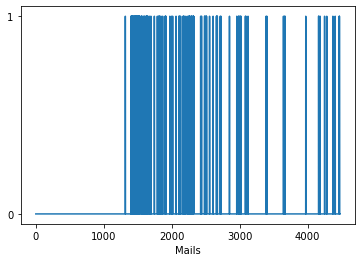

IFrame


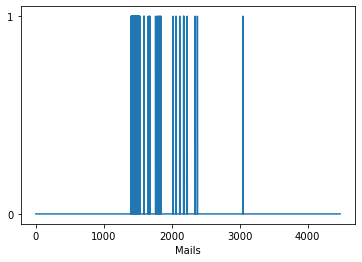

FlashContent


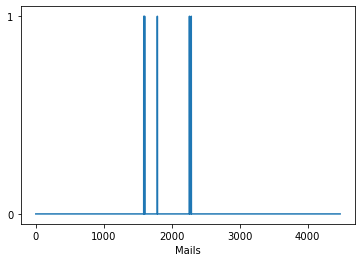

General Salutation


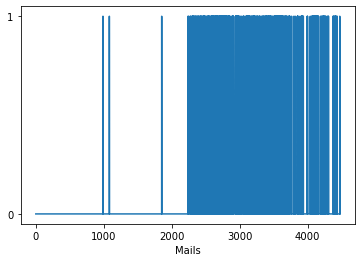

Javascript


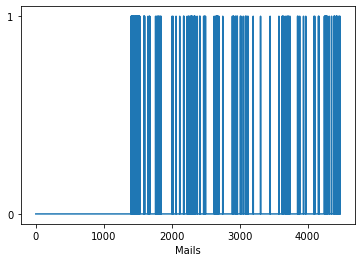

Number of URLs


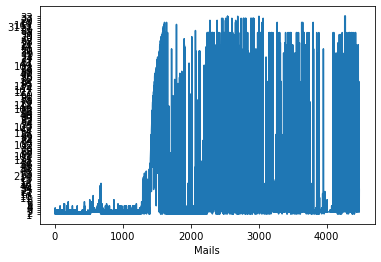

Malicious URL


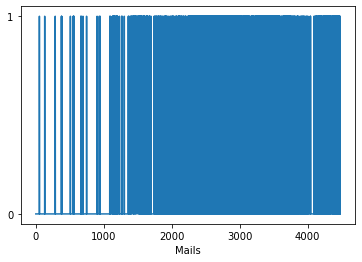

text link disparity


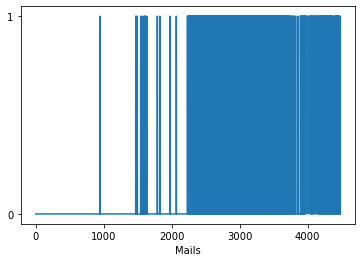

Attachments


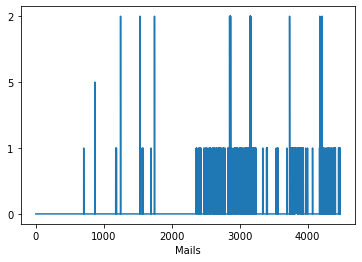

IP URLs


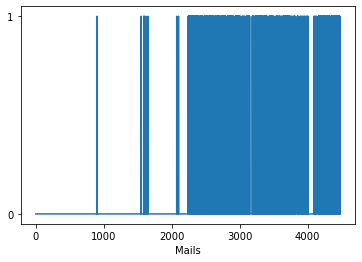

hexadecimal URL


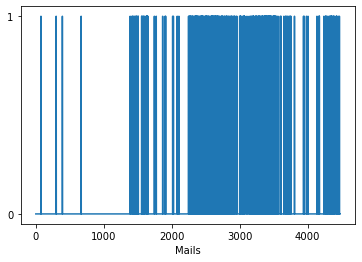

Bad Rank Domain


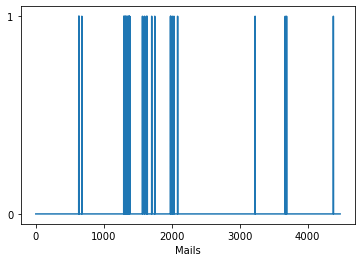

Maximum Domains Counts


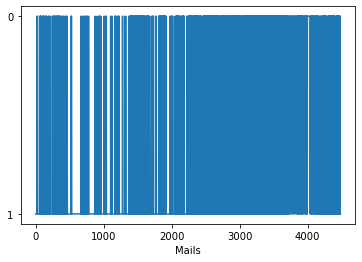

Class


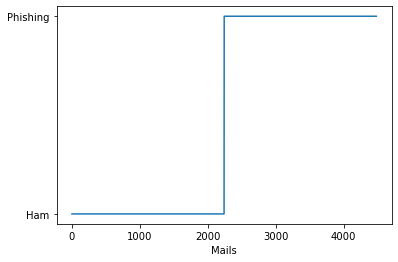

In [11]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_data():
        feature_val = np.array(rows).T
        xpoints = np.arange(1,len(rows)+1,1)
        for i in range(1,15,1):
            ypoints = np.array(feature_val[i])
            print(fields[i])          
            
            plt.xlabel("Mails")
            plt.plot(xpoints, ypoints)
            plt.show()
        
visualize_data()

### Histogram, PDF and CDF

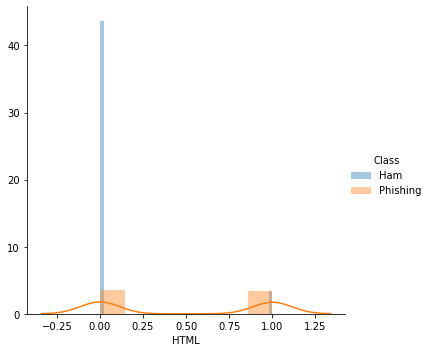

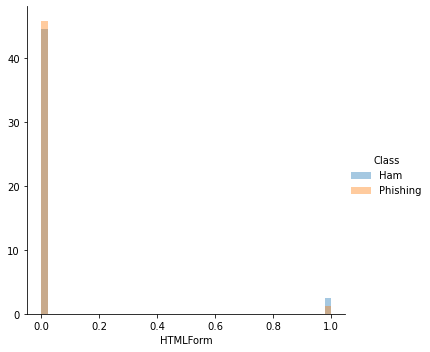

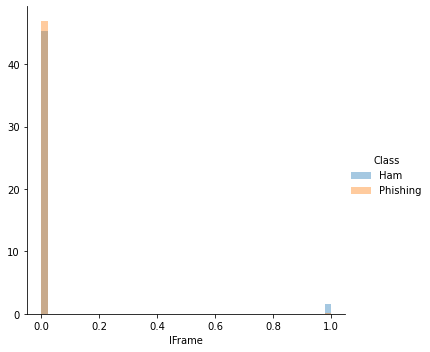

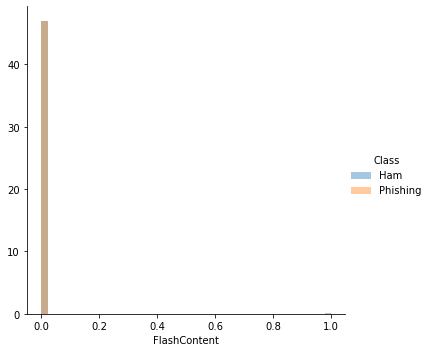

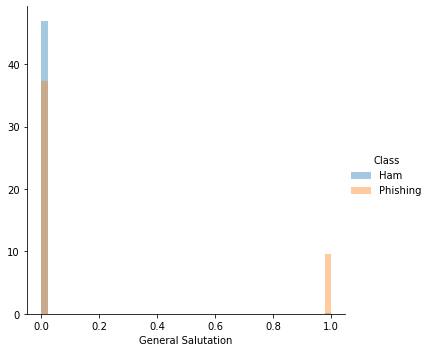

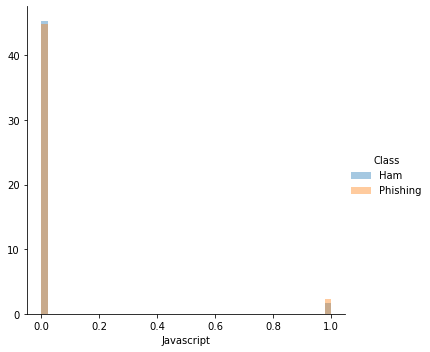

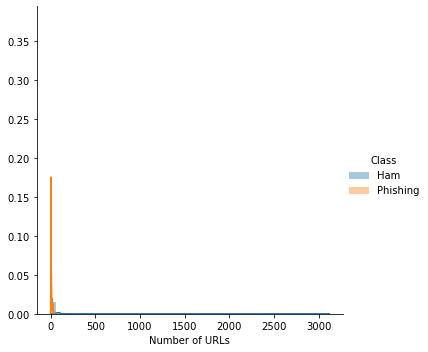

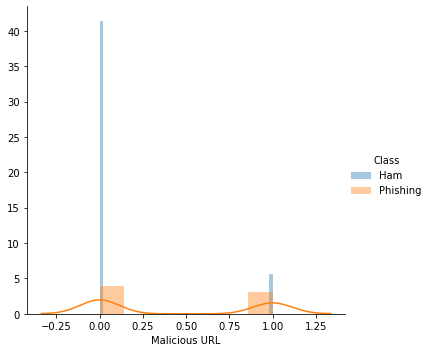

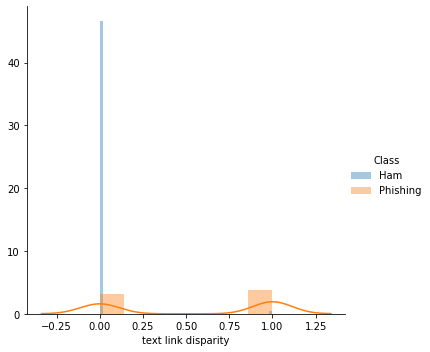

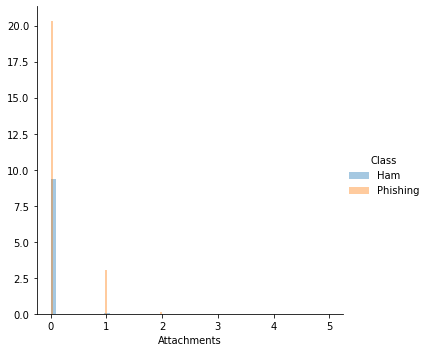

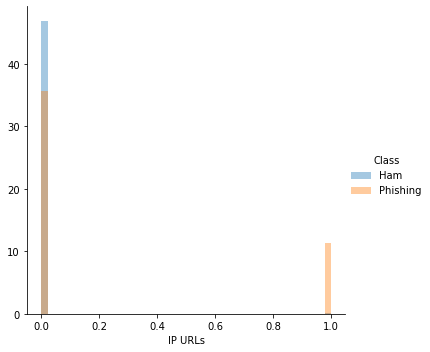

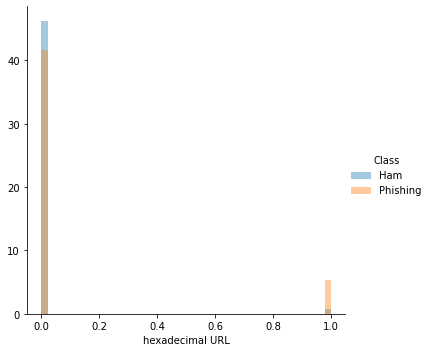

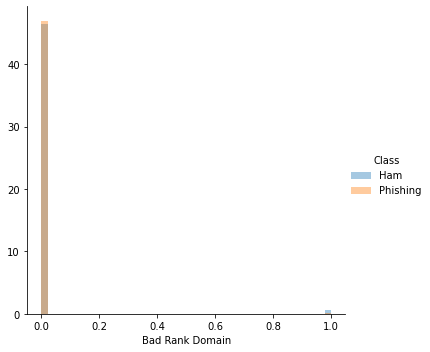

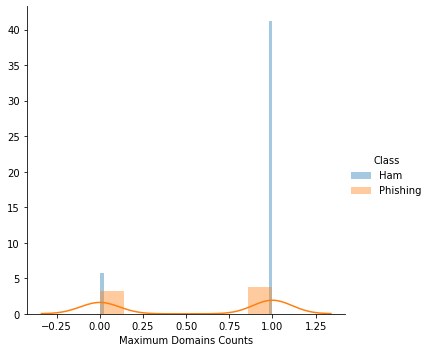

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
mails = pd.read_csv("./dataset/mails_dataset.csv")

columns = mails.columns[:14]
for column in columns:
    sns.FacetGrid(mails, hue="Class", height=5) \
       .map(sns.distplot, column) \
       .add_legend();
    plt.show();

#     sns.displot(penguins, x=column , hue="species", kind="kde", multiple="stack")


### Violin plots

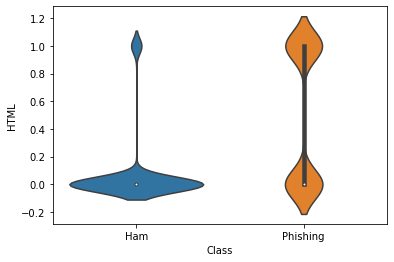

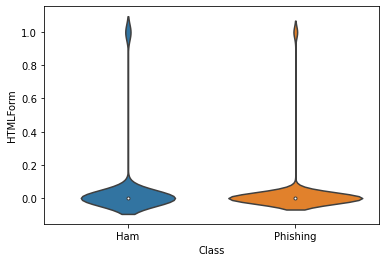

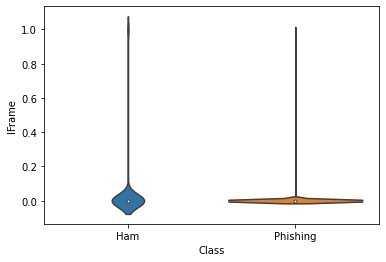

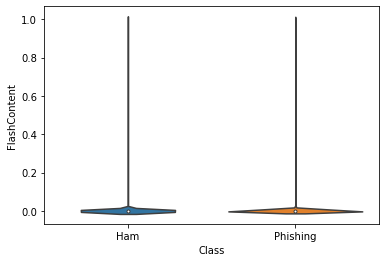

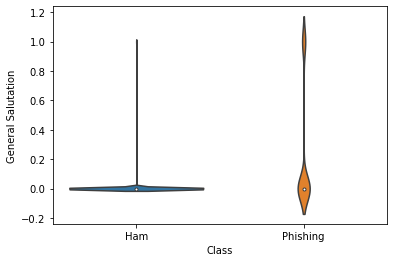

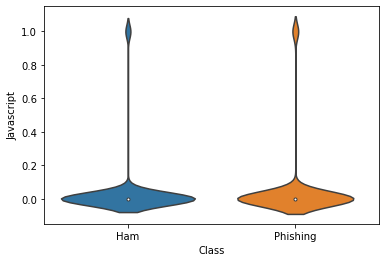

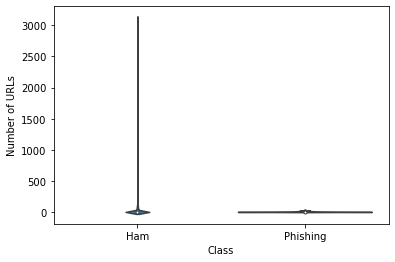

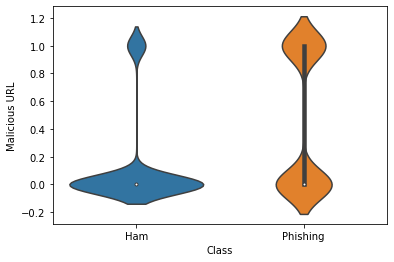

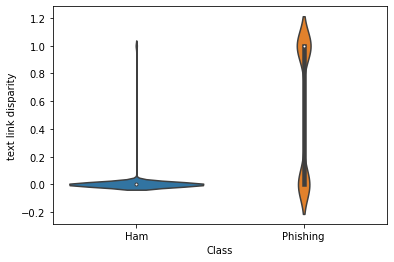

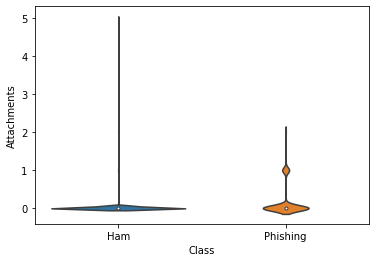

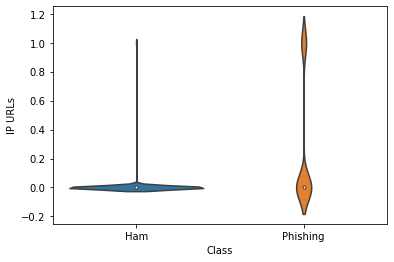

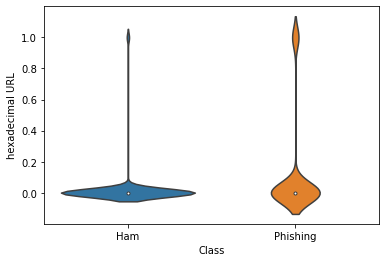

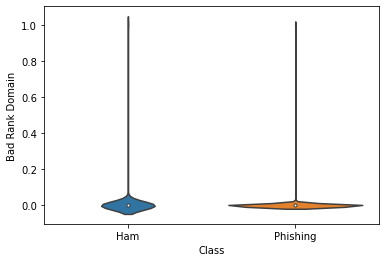

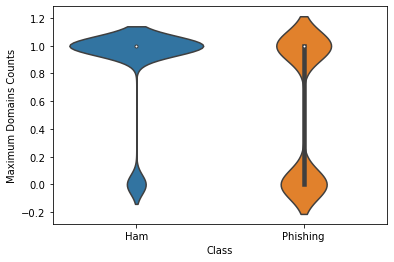

In [4]:

for column in columns:
    sns.violinplot(x="Class", y=column, data=mails, size=8)
    plt.show()
  


### Principal Component Analysis

#### PCA for visualization

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

d0 = mails.copy(deep=True)
dataFrame = shuffle(d0)
print(dataFrame['Class'].shape)
data = dataFrame
labels = data['Class']


# Drop the label feature and store the pixel data in d.
data = data.drop("Class",axis=1)
print(labels.shape)
print(data.shape)
print(dataFrame.head())


(4478,)
(4478,)
(4478, 14)
      HTML  HTMLForm  IFrame  FlashContent  General Salutation  Javascript  \
3242     1         0       0             0                   0           0   
3090     1         0       0             0                   0           0   
1681     0         0       0             0                   0           0   
2699     1         0       0             0                   0           0   
2343     1         0       0             0                   0           0   

      Number of URLs  Malicious URL  text link disparity  Attachments  \
3242              25              1                    1            0   
3090               3              0                    1            0   
1681               1              0                    0            0   
2699               1              0                    0            0   
2343               6              0                    1            0   

      IP URLs  hexadecimal URL  Bad Rank Domain  Maximum Domains 

In [6]:
# initializing the pca
from sklearn import decomposition
import seaborn as sn
from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler().fit_transform(data)
print(standardized_data.shape)
data  = standardized_data
pca = decomposition.PCA()

# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(data)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, labels)).T

(4478, 14)
shape of pca_reduced.shape =  (4478, 2)


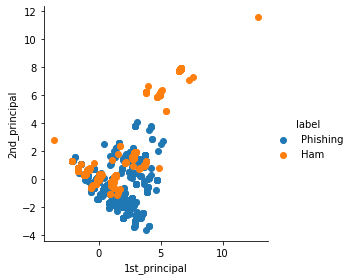

In [8]:
# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", size=4).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

#### PCA for dimentionality reduction

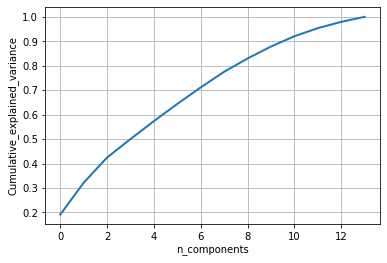

In [9]:
# PCA for dimensionality redcution (non-visualization)

pca.n_components = 14
pca_data = pca.fit_transform(data)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


# If we take 9-dimensions, approx. 90% of variance is expalined.

As we can see from the graph, if we take 10 features we are preserving more than 90% variance.

### t-SNE using Scikit-Learn

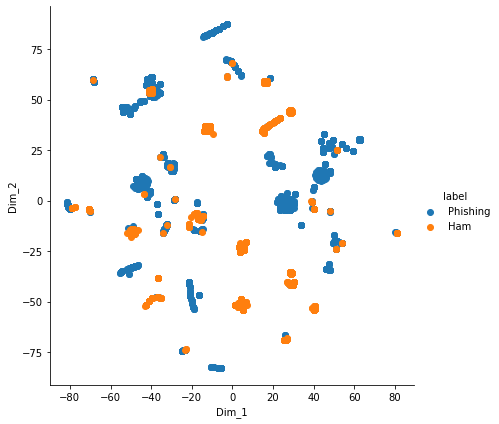

In [10]:
# TSNE

from sklearn.manifold import TSNE


model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

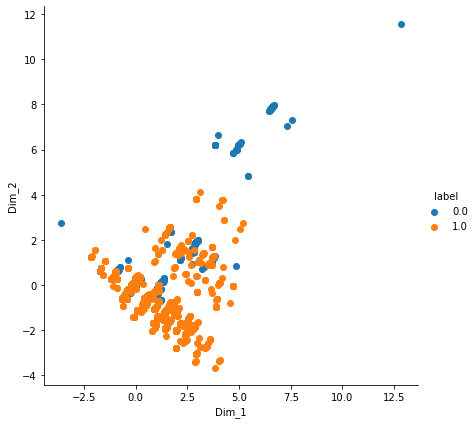

In [12]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd_data = svd.fit_transform(data)

svd_data = np.vstack((svd_data.T, labels)).T
svd_df = pd.DataFrame(data=svd_data, columns=("Dim_1", "Dim_2", "label"))
palette =(zip(svd_data, sns.color_palette()))
# palette.update({"Total":"k"})
# Ploting the result of tsne
palette = sns.color_palette()
sn.FacetGrid(svd_df, hue="label",palette=palette, size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

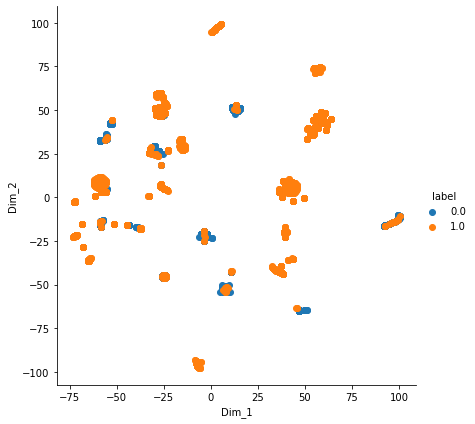

In [13]:
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

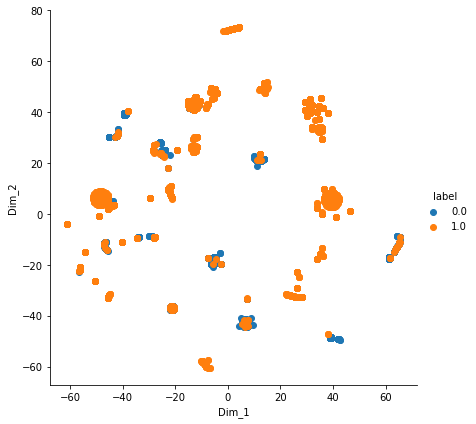

In [14]:
model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = model.fit_transform(data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [15]:
from sklearn.ensemble import RandomForestRegressor
df = dataFrame.copy(deep=True)
print(df.head())
model = RandomForestRegressor(random_state=1, max_depth=10)
dic = {"Ham": 0,"Phishing": 1}
df['Class']= df['Class'].replace(dic)
labels = df['Class']
df = df.drop('Class',axis = 1)
print(df.shape,labels.shape)
model.fit(df,labels)

      HTML  HTMLForm  IFrame  FlashContent  General Salutation  Javascript  \
3242     1         0       0             0                   0           0   
3090     1         0       0             0                   0           0   
1681     0         0       0             0                   0           0   
2699     1         0       0             0                   0           0   
2343     1         0       0             0                   0           0   

      Number of URLs  Malicious URL  text link disparity  Attachments  \
3242              25              1                    1            0   
3090               3              0                    1            0   
1681               1              0                    0            0   
2699               1              0                    0            0   
2343               6              0                    1            0   

      IP URLs  hexadecimal URL  Bad Rank Domain  Maximum Domains Counts  \
3242        0    

RandomForestRegressor(max_depth=10, random_state=1)

Index(['HTML', 'HTMLForm', 'IFrame', 'FlashContent', 'General Salutation',
       'Javascript', 'Number of URLs', 'Malicious URL', 'text link disparity',
       'Attachments', 'IP URLs', 'hexadecimal URL', 'Bad Rank Domain',
       'Maximum Domains Counts'],
      dtype='object')
[1.57849747e-01 4.62228596e-04 2.08497714e-03 7.45236271e-04
 2.71586371e-02 1.62510378e-03 1.53682014e-01 6.77047941e-03
 3.97290002e-01 1.79773065e-01 6.33708742e-02 2.98943766e-03
 6.75366523e-05 6.13066108e-03]
[ 1  3  5  2 11 13  7  4 10  6  0  9  8]


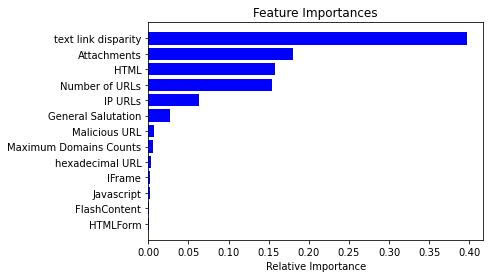

In [16]:
features = df.columns
print(features)
importances = model.feature_importances_
print(importances)
indices = np.argsort(importances)[-13:]  # top 10 features
print(indices)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import datasets
df = dataFrame.copy(deep=True)
dic = {"Ham": 0,"Phishing": 1}
df['Class']= df['Class'].replace(dic)
labels = df['Class']
df = df.drop('Class',axis = 1)

lreg = LinearRegression()
rfe = RFE(lreg, 10)
rfe = rfe.fit_transform(data, labels)

In [ ]:
def headersFilters(mails, label):
    mail = mails[130]
    msg = email.message_from_string(mail)
    print(msg.get_charset())
    #         for part in msg.get_payload():
    #             print (part)
    #         print(msg.is_multipart())
    print("==============================\n\n")
    print(msg.keys())
    print(len(msg["Received"]))

    for part in msg.walk():
        print(part.get_content_type())


headersFilters(phishing, 1)
headersFilters(ham, 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

In [ ]:
# check dataset shapes
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))